In [29]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
import time
import re
import tensorflow as tf
import tensorflow_hub as hub
import pickle
import os
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import string

from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Lambda
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, TimeDistributed
from datetime import datetime

%matplotlib inline

os.chdir("/Users/alexdessouky/Desktop/MIDS/w266")

#load training data
twitter_train = pd.read_excel('./w266_final_project/StanceDataset/train.xlsx')

#load test data
twitter_test = pd.read_excel('./w266_final_project/StanceDataset/test.xlsx')

In [30]:
twitter_train.head()


,Tweet,Target,Stance,Opinion Towards,Sentiment
0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos
2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,pos


In [31]:
twitter_test.head()
twitter_test.shape

(1956, 5)

In [48]:
393 / 689

0.5703918722786647

In [47]:
twitter_train[(twitter_train['Target'] == 'Hillary Clinton')]

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos
2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,pos
...,...,...,...,...,...
2306,Today's number is 8! That's how many years old...,Hillary Clinton,AGAINST,2. The tweet does NOT expresses opinion about ...,pos
2307,@JessieJaneDuff Results matter. U may feel les...,Hillary Clinton,AGAINST,2. The tweet does NOT expresses opinion about ...,neg
2308,Grateful for the chance to tell the world abou...,Hillary Clinton,AGAINST,2. The tweet does NOT expresses opinion about ...,pos
2309,"If you cant dazzle them with brilliance, baffl...",Hillary Clinton,AGAINST,2. The tweet does NOT expresses opinion about ...,neg


## Code for loading full Elmo outputs from pickle files and prepping labelled data

In [32]:
# ELMO OUTPUTS
with open("./ELMO Outputs v.2/elmo_train.pickle", "rb") as f:
    train_vectors = pickle.load(f)
    
with open("./ELMO Outputs v.2/elmo_test.pickle", "rb") as f:
    test_vectors = pickle.load(f)

In [33]:
#PREP LABELS
stance_labels_train = np.array(twitter_train['Stance'].apply(lambda x: 
                                                                    2 if x == "FAVOR" else 
                                                                    (1 if x == "NONE" else 0)))

stance_labels_test = np.array(twitter_test['Stance'].apply(lambda x: 
                                                                    2 if x == "FAVOR" else 
                                                                    (1 if x == "NONE" else 0)))

In [34]:
#PREP LABELS FOR NN
train_y = np.zeros(shape = (stance_labels_train.shape[0],3))
train_y[stance_labels_train == 0,0] = 1
train_y[stance_labels_train == 1,1] = 1
train_y[stance_labels_train == 2,2] = 1

test_y = np.zeros(shape = (stance_labels_test.shape[0],3))
test_y[stance_labels_test == 0,0] = 1
test_y[stance_labels_test == 1,1] = 1
test_y[stance_labels_test == 2,2] = 1

## Helper function to obtain topic training / dev subsets

In [35]:
def topic_subset(topic_list, layer):
        
    #convert topic list to lower case
    for i in range(0,len(topic_list)):
        topic_list[i] = topic_list[i].lower()
    
    #find boolean series of all rows pertaining to the relevant topics
    matches_train = twitter_train['Target'].apply(lambda x: x.lower() in topic_list)
    matches_test = twitter_test['Target'].apply(lambda x: x.lower() in topic_list)
    
    #subset data and labels
    train_labels = train_y[matches_train,:]
    test_labels = test_y[matches_test,:]
    
    #pull features
    train_data = train_vectors[layer][matches_train,:,:]
    test_data = np.pad(test_vectors[layer], pad_width = ((0,0),(1,1),(0,0)), 
                      mode = 'constant', constant_values = 0)[matches_test,:,:]
    
    #also need to return the test labels in this format for metrics
    true_labels = stance_labels_test[matches_test]
    
    return train_data, train_labels, test_data, test_labels, true_labels

## Helper function for model performances

In [36]:
def confusion_plot(confusion_matrix, target_names):
    # Plot confusion matrix (via imshow)
    plt.imshow(confusion_matrix, interpolation = "nearest", cmap = plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    # Loop through each value of the matrix to add data labels
    width, height = confusion_matrix.shape
    for x in range(width):
        for y in range(height):
            plt.annotate(str(confusion_matrix[x][y]), xy = (y, x), 
                        horizontalalignment = "center",
                        verticalalignment = "center")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [37]:
def metrics(true_labels, test_probs):
    
    #find predicted labels
    test_predicts = np.argmax(test_probs, axis = 1)
    
    #calculate f1 score
    f1 = f1_score(true_labels, test_predicts, average = 'macro')
    
    print("F1 macro score:", f1)
    
    print(classification_report(y_true = true_labels, 
                                        y_pred = test_predicts,
                                        target_names = ['Against', 'None', 'Favor']))
    
    confuse = confusion_matrix(y_true = true_labels, y_pred = test_predicts)
    
    plt.figure(figsize=(15, 5))
    confusion_plot(confuse, ['Against', 'None', 'Favor'])
    plt.show()

## Define model

In [27]:
class ElmoEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        self.dimensions = 1024
        self.trainable = True
        super(ElmoEmbeddingLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        self.elmo = hub.Module('https://tfhub.dev/google/elmo/2', 
                                   trainable=self.trainable, name="{}_module".format(self.name))
        self.trainable_weights += K.tf.trainable_variables(scope="^{}_module/.*".format(self.name))
        super(ElmoEmbeddingLayer, self).build(input_shape)
    def call(self, x, mask=None):
        result = self.elmo(K.squeeze(K.cast(x, tf.string), axis=1),
                          as_dict=True,
                          signature='default',
                          )['default']
        return result
    def compute_mask(self, inputs, mask=None):
        return K.not_equal(inputs, '--PAD--')
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.dimensions)
        
        
input_text = layers.Input(shape=(1,), dtype=tf.string)
embedding = ElmoEmbeddingLayer()(input_text)
dense = layers.Dense(256, activation='relu')(embedding)
pred = layers.Dense(1, activation='sigmoid')(dense)

model = Model(inputs=[input_text], outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = ['categorical_accuracy'])
model.summary()

AttributeError: module 'tensorflow.keras.backend' has no attribute 'tensorflow'

In [38]:
def feed_forward(activation_function = 'tanh', 
                optimizer='adam', 
                kernel_initializer=tf.keras.initializers.he_normal(seed=123), 
                bias_initializer='zeros'):
    
    
    
    
    # Define Input layer(s)
    input_vectors = tf.keras.layers.Input(shape=(32,1024), name="input_numbers")
    
    
    #First dense layer with dropout
    dense1 = tf.keras.layers.Dense(16, input_shape = (32,1024),
                                 activation = activation_function,
                                 kernel_initializer = kernel_initializer,
                                 bias_initializer = bias_initializer,
                                 kernel_regularizer=tf.keras.regularizers.l2(0.01),
                                 activity_regularizer=tf.keras.regularizers.l1(0.01))
    dense1_outputs = dense1(input_vectors)
    
    drop1 = tf.keras.layers.Dropout(0.5)
    drop1_outputs = drop1(dense1_outputs)
    
    
    #Second dense layer with dropout
    dense2 = tf.keras.layers.Dense(32, activation = activation_function,
                                 kernel_initializer = kernel_initializer,
                                 bias_initializer = bias_initializer,
                                 kernel_regularizer=tf.keras.regularizers.l2(0.01),
                                 activity_regularizer=tf.keras.regularizers.l1(0.01))
    dense2_outputs = dense2(drop1_outputs)
    
    drop2 = tf.keras.layers.Dropout(0.5)
    drop2_outputs = drop2(dense2_outputs)
    
    #Third dense layer with dropout
    dense3 = tf.keras.layers.Dense(64, activation = activation_function,
                                 kernel_initializer = kernel_initializer,
                                 bias_initializer = bias_initializer,
                                 kernel_regularizer=tf.keras.regularizers.l2(0.01),
                                 activity_regularizer=tf.keras.regularizers.l1(0.01))
    dense3_outputs = dense3(drop2_outputs)

    drop3 = tf.keras.layers.Dropout(0.5)
    drop3_outputs = drop3(dense3_outputs)

    #Flatten output of third dense layer
    flatten = tf.keras.layers.Flatten(data_format=None)
    flatten_outputs = flatten(drop3_outputs)
    
    #define classification layer (softmax since we have 3 classes)
    classification_layer = tf.keras.layers.Dense(3, kernel_initializer = kernel_initializer,
                                                 activation='softmax', name='classification',
                                                 bias_initializer = bias_initializer) # layer definition
                            
    classification_output = classification_layer(flatten_outputs)   # layer acting on previous layer's output

    # Build and compile model
    ff_mod = tf.keras.models.Model(input_vectors, classification_output)
    
    ff_mod.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = ['categorical_accuracy'])
    
    return ff_mod

ff_mod = feed_forward()
ff_mod.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_numbers (InputLayer)   [(None, 32, 1024)]        0         
_________________________________________________________________
dense (Dense)                (None, 32, 16)            16400     
_________________________________________________________________
dropout (Dropout)            (None, 32, 16)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 32, 32)            544       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 32, 64)            2112      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 64)            0     

# Run LSTM on 'ELMO' outputs

In [44]:
#Atheism

#obtain subset data
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(['Atheism'], 'elmo')
weights = {0: train_labels[:,0].sum(), 1:train_labels[:,1].sum(), 2:train_labels[:,2].sum()}


#train model
ff_mod.fit(
        train_data,
        train_labels,
        epochs=100,
        batch_size = 100,
        verbose=2,
        validation_split = 0.2,
        shuffle = True)
        #class_weight = weights)

#make predictions
test_probs = ff_mod.predict(test_data)

Train on 410 samples, validate on 103 samples
Epoch 1/100
410/410 - 1s - loss: 5.5701 - categorical_accuracy: 1.0000 - val_loss: 8.0669 - val_categorical_accuracy: 0.6699
Epoch 2/100
410/410 - 0s - loss: 5.5239 - categorical_accuracy: 1.0000 - val_loss: 8.0649 - val_categorical_accuracy: 0.6699
Epoch 3/100
410/410 - 0s - loss: 5.5269 - categorical_accuracy: 1.0000 - val_loss: 8.0662 - val_categorical_accuracy: 0.6602
Epoch 4/100
410/410 - 0s - loss: 5.4907 - categorical_accuracy: 0.9976 - val_loss: 8.0660 - val_categorical_accuracy: 0.6505
Epoch 5/100
410/410 - 0s - loss: 5.4783 - categorical_accuracy: 1.0000 - val_loss: 8.0650 - val_categorical_accuracy: 0.6408
Epoch 6/100
410/410 - 0s - loss: 5.4098 - categorical_accuracy: 0.9951 - val_loss: 8.0616 - val_categorical_accuracy: 0.6408
Epoch 7/100
410/410 - 0s - loss: 5.3765 - categorical_accuracy: 0.9976 - val_loss: 8.0570 - val_categorical_accuracy: 0.6408
Epoch 8/100
410/410 - 0s - loss: 5.3404 - categorical_accuracy: 0.9951 - val_lo

Epoch 66/100
410/410 - 0s - loss: 3.9182 - categorical_accuracy: 1.0000 - val_loss: 5.8052 - val_categorical_accuracy: 0.5922
Epoch 67/100
410/410 - 0s - loss: 3.8946 - categorical_accuracy: 0.9976 - val_loss: 5.7625 - val_categorical_accuracy: 0.5922
Epoch 68/100
410/410 - 0s - loss: 3.8963 - categorical_accuracy: 0.9976 - val_loss: 5.7182 - val_categorical_accuracy: 0.5922
Epoch 69/100
410/410 - 0s - loss: 3.8561 - categorical_accuracy: 0.9951 - val_loss: 5.6794 - val_categorical_accuracy: 0.6019
Epoch 70/100
410/410 - 0s - loss: 3.8509 - categorical_accuracy: 0.9976 - val_loss: 5.6407 - val_categorical_accuracy: 0.6019
Epoch 71/100
410/410 - 0s - loss: 3.8270 - categorical_accuracy: 1.0000 - val_loss: 5.6010 - val_categorical_accuracy: 0.6019
Epoch 72/100
410/410 - 0s - loss: 3.8127 - categorical_accuracy: 0.9927 - val_loss: 5.5622 - val_categorical_accuracy: 0.5922
Epoch 73/100
410/410 - 0s - loss: 3.7915 - categorical_accuracy: 0.9927 - val_loss: 5.5233 - val_categorical_accuracy:

F1 macro score: 0.494670672822467
              precision    recall  f1-score   support

     Against       0.89      0.60      0.72       160
        None       0.27      0.64      0.38        28
       Favor       0.33      0.47      0.38        32

   micro avg       0.59      0.59      0.59       220
   macro avg       0.50      0.57      0.49       220
weighted avg       0.73      0.59      0.63       220



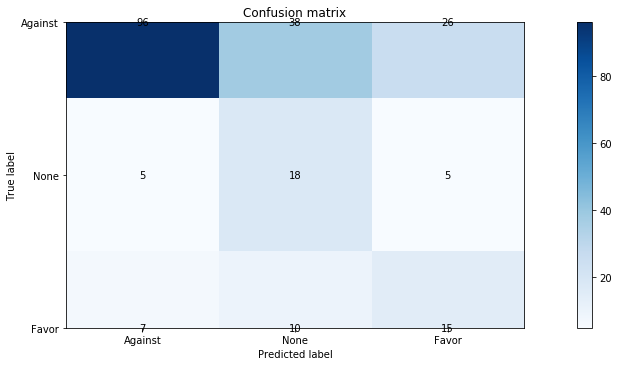

In [45]:
#show metrics
metrics(true_labels, test_probs)

In [19]:
#Hillary Clinton

#obtain subset data
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(['Hillary Clinton'], 'elmo')
weights = {0: train_labels[:,0].sum(), 1:train_labels[:,1].sum(), 2:train_labels[:,2].sum()}


#train model
ff_mod.fit(
        train_data,
        train_labels,
        epochs=100,
        batch_size = 100,
        verbose=2,
        validation_split = 0.2,
        shuffle = True,
        class_weight = weights)

#make predictions
test_probs = ff_mod.predict(test_data)

Train on 551 samples, validate on 138 samples
Epoch 1/100
551/551 - 0s - loss: 482.4100 - categorical_accuracy: 0.6171 - val_loss: 228.6363 - val_categorical_accuracy: 0.8333
Epoch 2/100
551/551 - 0s - loss: 296.7233 - categorical_accuracy: 0.6715 - val_loss: 115.3254 - val_categorical_accuracy: 0.8768
Epoch 3/100
551/551 - 0s - loss: 166.8203 - categorical_accuracy: 0.7459 - val_loss: 84.0651 - val_categorical_accuracy: 0.9275
Epoch 4/100
551/551 - 0s - loss: 127.6602 - categorical_accuracy: 0.8113 - val_loss: 62.9986 - val_categorical_accuracy: 0.9275
Epoch 5/100
551/551 - 0s - loss: 108.9160 - categorical_accuracy: 0.7913 - val_loss: 60.2547 - val_categorical_accuracy: 0.9130
Epoch 6/100
551/551 - 0s - loss: 93.3128 - categorical_accuracy: 0.8439 - val_loss: 65.8723 - val_categorical_accuracy: 0.9275
Epoch 7/100
551/551 - 0s - loss: 86.6838 - categorical_accuracy: 0.8439 - val_loss: 51.7837 - val_categorical_accuracy: 0.9275
Epoch 8/100
551/551 - 0s - loss: 71.0240 - categorical_acc

Epoch 65/100
551/551 - 0s - loss: 22.2280 - categorical_accuracy: 0.9891 - val_loss: 83.1976 - val_categorical_accuracy: 0.9275
Epoch 66/100
551/551 - 0s - loss: 21.0001 - categorical_accuracy: 0.9909 - val_loss: 75.5093 - val_categorical_accuracy: 0.9275
Epoch 67/100
551/551 - 0s - loss: 23.2617 - categorical_accuracy: 0.9673 - val_loss: 90.9613 - val_categorical_accuracy: 0.9203
Epoch 68/100
551/551 - 0s - loss: 25.3414 - categorical_accuracy: 0.9764 - val_loss: 78.4338 - val_categorical_accuracy: 0.9275
Epoch 69/100
551/551 - 0s - loss: 25.7676 - categorical_accuracy: 0.9800 - val_loss: 92.2633 - val_categorical_accuracy: 0.9058
Epoch 70/100
551/551 - 0s - loss: 20.3923 - categorical_accuracy: 0.9819 - val_loss: 88.9253 - val_categorical_accuracy: 0.9275
Epoch 71/100
551/551 - 0s - loss: 22.3502 - categorical_accuracy: 0.9764 - val_loss: 97.1862 - val_categorical_accuracy: 0.9130
Epoch 72/100
551/551 - 0s - loss: 20.7817 - categorical_accuracy: 0.9873 - val_loss: 115.6126 - val_cate

F1 macro score: 0.5071321482116083
              precision    recall  f1-score   support

     Against       0.69      0.79      0.74       172
        None       0.54      0.46      0.50        78
       Favor       0.34      0.24      0.29        45

   micro avg       0.62      0.62      0.62       295
   macro avg       0.52      0.50      0.51       295
weighted avg       0.60      0.62      0.61       295



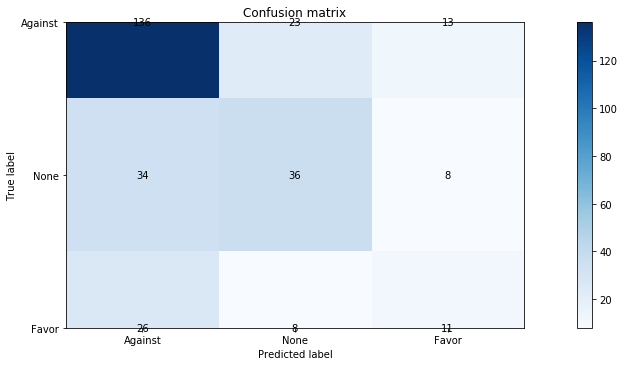

In [20]:
#show metrics
metrics(true_labels, test_probs)

In [16]:
#Abortion

#obtain subset data
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(['Legalization of Abortion'], 'elmo')
weights = {0: train_labels[:,0].sum(), 1:train_labels[:,1].sum(), 2:train_labels[:,2].sum()}


#train model
ff_mod.fit(
        train_data,
        train_labels,
        epochs=100,
        batch_size = 100,
        verbose=2,
        validation_split = 0.2,
        shuffle = True,
        class_weight = weights)

#make predictions
test_probs = ff_mod.predict(test_data)

Train on 522 samples, validate on 131 samples
Epoch 1/100
522/522 - 0s - loss: 681.0883 - categorical_accuracy: 0.4406 - val_loss: 392.0829 - val_categorical_accuracy: 0.7023
Epoch 2/100
522/522 - 0s - loss: 475.0944 - categorical_accuracy: 0.5000 - val_loss: 526.5023 - val_categorical_accuracy: 0.5573
Epoch 3/100
522/522 - 0s - loss: 314.3124 - categorical_accuracy: 0.5326 - val_loss: 270.7539 - val_categorical_accuracy: 0.6718
Epoch 4/100
522/522 - 0s - loss: 275.2511 - categorical_accuracy: 0.5670 - val_loss: 324.2598 - val_categorical_accuracy: 0.5954
Epoch 5/100
522/522 - 0s - loss: 226.6876 - categorical_accuracy: 0.6073 - val_loss: 254.1283 - val_categorical_accuracy: 0.6260
Epoch 6/100
522/522 - 0s - loss: 217.7935 - categorical_accuracy: 0.6034 - val_loss: 255.9204 - val_categorical_accuracy: 0.6031
Epoch 7/100
522/522 - 0s - loss: 195.7389 - categorical_accuracy: 0.6494 - val_loss: 253.6335 - val_categorical_accuracy: 0.6183
Epoch 8/100
522/522 - 0s - loss: 184.5003 - categor

522/522 - 0s - loss: 39.4711 - categorical_accuracy: 0.9502 - val_loss: 522.1140 - val_categorical_accuracy: 0.6565
Epoch 65/100
522/522 - 0s - loss: 39.1974 - categorical_accuracy: 0.9483 - val_loss: 634.8054 - val_categorical_accuracy: 0.6183
Epoch 66/100
522/522 - 0s - loss: 39.9954 - categorical_accuracy: 0.9444 - val_loss: 652.2251 - val_categorical_accuracy: 0.6183
Epoch 67/100
522/522 - 0s - loss: 33.2604 - categorical_accuracy: 0.9674 - val_loss: 590.1181 - val_categorical_accuracy: 0.6412
Epoch 68/100
522/522 - 0s - loss: 42.2295 - categorical_accuracy: 0.9330 - val_loss: 701.6385 - val_categorical_accuracy: 0.6183
Epoch 69/100
522/522 - 0s - loss: 34.8530 - categorical_accuracy: 0.9598 - val_loss: 614.2631 - val_categorical_accuracy: 0.6489
Epoch 70/100
522/522 - 0s - loss: 37.0701 - categorical_accuracy: 0.9540 - val_loss: 707.6492 - val_categorical_accuracy: 0.6031
Epoch 71/100
522/522 - 0s - loss: 34.7605 - categorical_accuracy: 0.9617 - val_loss: 638.7742 - val_categorica

F1 macro score: 0.531648178058237
              precision    recall  f1-score   support

     Against       0.80      0.63      0.71       189
        None       0.33      0.73      0.46        45
       Favor       0.52      0.37      0.43        46

   micro avg       0.60      0.60      0.60       280
   macro avg       0.55      0.58      0.53       280
weighted avg       0.68      0.60      0.62       280



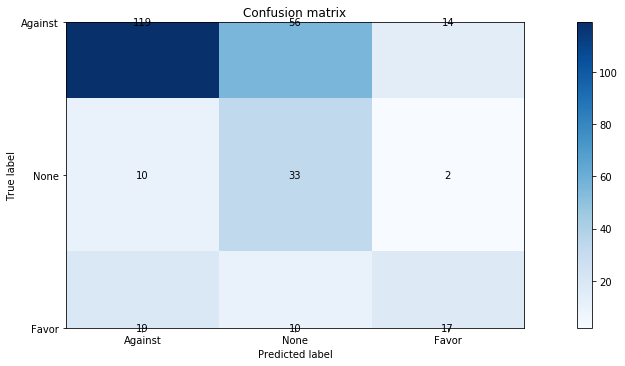

In [17]:
#show metrics
metrics(true_labels, test_probs)

In [18]:
#Climate

#obtain subset data
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(['Climate Change is a Real Concern'], 'elmo')
weights = {0: train_labels[:,0].sum(), 1:train_labels[:,1].sum(), 2:train_labels[:,2].sum()}


#train model
ff_mod.fit(
        train_data,
        train_labels,
        epochs=100,
        batch_size = 100,
        verbose=2,
        validation_split = 0.2,
        shuffle = True,
        class_weight = weights)

#make predictions
test_probs = ff_mod.predict(test_data)

Train on 316 samples, validate on 79 samples
Epoch 1/100
316/316 - 0s - loss: 872.9624 - categorical_accuracy: 0.3829 - val_loss: 524.6384 - val_categorical_accuracy: 0.4557
Epoch 2/100
316/316 - 0s - loss: 404.2536 - categorical_accuracy: 0.5443 - val_loss: 251.8887 - val_categorical_accuracy: 0.5316
Epoch 3/100
316/316 - 0s - loss: 252.7310 - categorical_accuracy: 0.5475 - val_loss: 185.2721 - val_categorical_accuracy: 0.6582
Epoch 4/100
316/316 - 0s - loss: 218.4999 - categorical_accuracy: 0.5981 - val_loss: 298.4313 - val_categorical_accuracy: 0.4937
Epoch 5/100
316/316 - 0s - loss: 181.3206 - categorical_accuracy: 0.6424 - val_loss: 208.7380 - val_categorical_accuracy: 0.5949
Epoch 6/100
316/316 - 0s - loss: 211.4382 - categorical_accuracy: 0.6076 - val_loss: 157.6667 - val_categorical_accuracy: 0.6582
Epoch 7/100
316/316 - 0s - loss: 157.4863 - categorical_accuracy: 0.6582 - val_loss: 257.2862 - val_categorical_accuracy: 0.5063
Epoch 8/100
316/316 - 0s - loss: 174.3049 - categori

Epoch 65/100
316/316 - 0s - loss: 30.7072 - categorical_accuracy: 0.9494 - val_loss: 284.7859 - val_categorical_accuracy: 0.6835
Epoch 66/100
316/316 - 0s - loss: 33.4563 - categorical_accuracy: 0.9399 - val_loss: 287.2231 - val_categorical_accuracy: 0.7215
Epoch 67/100
316/316 - 0s - loss: 30.2141 - categorical_accuracy: 0.9430 - val_loss: 286.9502 - val_categorical_accuracy: 0.7089
Epoch 68/100
316/316 - 0s - loss: 31.3675 - categorical_accuracy: 0.9525 - val_loss: 284.5588 - val_categorical_accuracy: 0.7089
Epoch 69/100
316/316 - 0s - loss: 25.0607 - categorical_accuracy: 0.9652 - val_loss: 286.8096 - val_categorical_accuracy: 0.6962
Epoch 70/100
316/316 - 0s - loss: 28.2540 - categorical_accuracy: 0.9557 - val_loss: 288.2769 - val_categorical_accuracy: 0.6962
Epoch 71/100
316/316 - 0s - loss: 25.5124 - categorical_accuracy: 0.9620 - val_loss: 288.5493 - val_categorical_accuracy: 0.7089
Epoch 72/100
316/316 - 0s - loss: 33.5182 - categorical_accuracy: 0.9399 - val_loss: 291.7134 - v

F1 macro score: 0.4753940600630496
              precision    recall  f1-score   support

     Against       0.00      0.00      0.00        11
        None       0.51      0.69      0.59        35
       Favor       0.84      0.84      0.84       123

   micro avg       0.75      0.75      0.75       169
   macro avg       0.45      0.51      0.48       169
weighted avg       0.72      0.75      0.73       169



/Users/alexdessouky/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alexdessouky/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


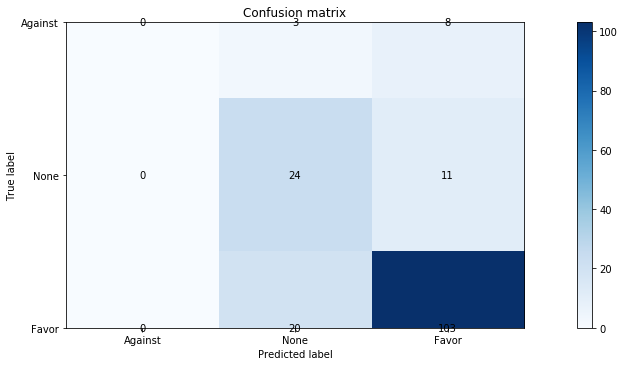

In [19]:
#show metrics
metrics(true_labels, test_probs)

In [20]:
#Feminism

#obtain subset data
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(['Feminist Movement'], 'elmo')
weights = {0: train_labels[:,0].sum(), 1:train_labels[:,1].sum(), 2:train_labels[:,2].sum()}


#train model
ff_mod.fit(
        train_data,
        train_labels,
        epochs=100,
        batch_size = 100,
        verbose=2,
        validation_split = 0.2,
        shuffle = True,
        class_weight = weights)

#make predictions
test_probs = ff_mod.predict(test_data)

Train on 531 samples, validate on 133 samples
Epoch 1/100
531/531 - 0s - loss: 930.1722 - categorical_accuracy: 0.3710 - val_loss: 379.6323 - val_categorical_accuracy: 0.7444
Epoch 2/100
531/531 - 0s - loss: 575.3172 - categorical_accuracy: 0.4162 - val_loss: 292.4570 - val_categorical_accuracy: 0.6541
Epoch 3/100
531/531 - 0s - loss: 380.6619 - categorical_accuracy: 0.4011 - val_loss: 224.2943 - val_categorical_accuracy: 0.6917
Epoch 4/100
531/531 - 0s - loss: 374.3132 - categorical_accuracy: 0.3879 - val_loss: 190.2184 - val_categorical_accuracy: 0.7669
Epoch 5/100
531/531 - 0s - loss: 339.3806 - categorical_accuracy: 0.4313 - val_loss: 219.1540 - val_categorical_accuracy: 0.6541
Epoch 6/100
531/531 - 0s - loss: 288.2415 - categorical_accuracy: 0.4350 - val_loss: 172.7448 - val_categorical_accuracy: 0.7594
Epoch 7/100
531/531 - 0s - loss: 271.8664 - categorical_accuracy: 0.4557 - val_loss: 165.3522 - val_categorical_accuracy: 0.7744
Epoch 8/100
531/531 - 0s - loss: 263.3525 - categor

Epoch 64/100
531/531 - 0s - loss: 96.7871 - categorical_accuracy: 0.8192 - val_loss: 566.3209 - val_categorical_accuracy: 0.4737
Epoch 65/100
531/531 - 0s - loss: 91.7076 - categorical_accuracy: 0.8380 - val_loss: 592.8437 - val_categorical_accuracy: 0.4737
Epoch 66/100
531/531 - 0s - loss: 88.8740 - categorical_accuracy: 0.8588 - val_loss: 575.3341 - val_categorical_accuracy: 0.4662
Epoch 67/100
531/531 - 0s - loss: 89.3825 - categorical_accuracy: 0.8512 - val_loss: 645.3856 - val_categorical_accuracy: 0.4586
Epoch 68/100
531/531 - 0s - loss: 92.4753 - categorical_accuracy: 0.8531 - val_loss: 585.1775 - val_categorical_accuracy: 0.4887
Epoch 69/100
531/531 - 0s - loss: 84.9771 - categorical_accuracy: 0.8456 - val_loss: 530.5835 - val_categorical_accuracy: 0.5038
Epoch 70/100
531/531 - 0s - loss: 78.4703 - categorical_accuracy: 0.8531 - val_loss: 675.0561 - val_categorical_accuracy: 0.4436
Epoch 71/100
531/531 - 0s - loss: 79.7733 - categorical_accuracy: 0.8719 - val_loss: 609.0245 - v

F1 macro score: 0.4580956022650859
              precision    recall  f1-score   support

     Against       0.73      0.51      0.60       183
        None       0.45      0.39      0.41        44
       Favor       0.27      0.55      0.36        58

   micro avg       0.50      0.50      0.50       285
   macro avg       0.48      0.48      0.46       285
weighted avg       0.59      0.50      0.52       285



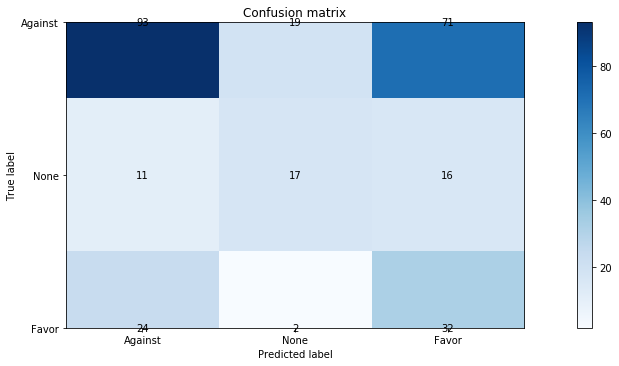

In [21]:
#show metrics
metrics(true_labels, test_probs)

In [22]:
#All

#obtain subset data
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(['Hillary Clinton', 
                                                                              'Legalization of Abortion', 
                                                                              'Climate Change is a Real Concern',
                                                                              'Feminist Movement', 
                                                                              'Atheism'], 'elmo')
weights = {0: train_labels[:,0].sum(), 1:train_labels[:,1].sum(), 2:train_labels[:,2].sum()}


#train model
ff_mod.fit(
        train_data,
        train_labels,
        epochs=100,
        batch_size = 100,
        verbose=2,
        validation_split = 0.2,
        shuffle = True,
        class_weight = weights)

#make predictions
test_probs = ff_mod.predict(test_data)

Train on 2331 samples, validate on 583 samples
Epoch 1/100
2331/2331 - 2s - loss: 1310.6603 - categorical_accuracy: 0.5405 - val_loss: 981.1730 - val_categorical_accuracy: 0.5849
Epoch 2/100
2331/2331 - 1s - loss: 920.4277 - categorical_accuracy: 0.5894 - val_loss: 982.5817 - val_categorical_accuracy: 0.6089
Epoch 3/100
2331/2331 - 1s - loss: 868.6214 - categorical_accuracy: 0.6075 - val_loss: 962.9569 - val_categorical_accuracy: 0.6244
Epoch 4/100
2331/2331 - 1s - loss: 802.2795 - categorical_accuracy: 0.6405 - val_loss: 1034.4517 - val_categorical_accuracy: 0.6055
Epoch 5/100
2331/2331 - 1s - loss: 768.0115 - categorical_accuracy: 0.6435 - val_loss: 910.0335 - val_categorical_accuracy: 0.6261
Epoch 6/100
2331/2331 - 1s - loss: 732.2875 - categorical_accuracy: 0.6650 - val_loss: 997.9827 - val_categorical_accuracy: 0.6123
Epoch 7/100
2331/2331 - 1s - loss: 715.0402 - categorical_accuracy: 0.6804 - val_loss: 992.0053 - val_categorical_accuracy: 0.6106
Epoch 8/100
2331/2331 - 1s - loss:

Epoch 63/100
2331/2331 - 1s - loss: 283.6712 - categorical_accuracy: 0.8867 - val_loss: 2143.5264 - val_categorical_accuracy: 0.5214
Epoch 64/100
2331/2331 - 1s - loss: 293.8544 - categorical_accuracy: 0.8769 - val_loss: 2157.4869 - val_categorical_accuracy: 0.5232
Epoch 65/100
2331/2331 - 1s - loss: 291.1330 - categorical_accuracy: 0.8812 - val_loss: 2122.2720 - val_categorical_accuracy: 0.5352
Epoch 66/100
2331/2331 - 1s - loss: 273.5909 - categorical_accuracy: 0.8769 - val_loss: 2200.4823 - val_categorical_accuracy: 0.5249
Epoch 67/100
2331/2331 - 1s - loss: 274.3228 - categorical_accuracy: 0.8782 - val_loss: 2242.1377 - val_categorical_accuracy: 0.5334
Epoch 68/100
2331/2331 - 1s - loss: 276.9783 - categorical_accuracy: 0.8859 - val_loss: 2386.1455 - val_categorical_accuracy: 0.5009
Epoch 69/100
2331/2331 - 1s - loss: 261.7051 - categorical_accuracy: 0.9022 - val_loss: 2424.6207 - val_categorical_accuracy: 0.5094
Epoch 70/100
2331/2331 - 1s - loss: 267.8442 - categorical_accuracy: 

F1 macro score: 0.5004037097005617
              precision    recall  f1-score   support

     Against       0.69      0.60      0.65       715
        None       0.38      0.42      0.40       230
       Favor       0.42      0.51      0.46       304

   micro avg       0.55      0.55      0.55      1249
   macro avg       0.50      0.51      0.50      1249
weighted avg       0.57      0.55      0.55      1249



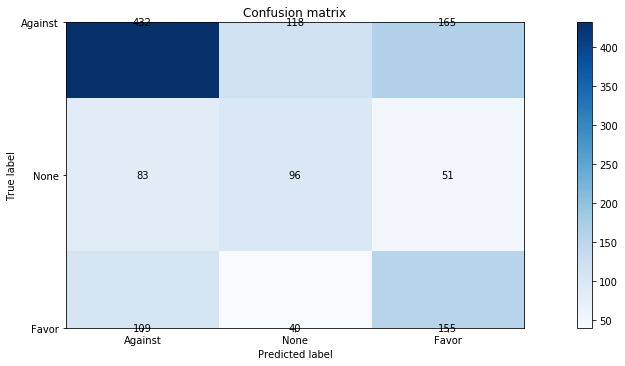

In [23]:
#show metrics
metrics(true_labels, test_probs)

# Run LSTM on 'LSTM1' outputs

In [24]:
#Atheism

#obtain subset data
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(['Atheism'], 'lstm_outputs1')
weights = {0: train_labels[:,0].sum(), 1:train_labels[:,1].sum(), 2:train_labels[:,2].sum()}


#train model
ff_mod.fit(
        train_data,
        train_labels,
        epochs=100,
        batch_size = 100,
        verbose=2,
        validation_split = 0.2,
        shuffle = True,
        class_weight = weights)

#make predictions
test_probs = ff_mod.predict(test_data)

Train on 410 samples, validate on 103 samples
Epoch 1/100
410/410 - 0s - loss: 282.8148 - categorical_accuracy: 0.6488 - val_loss: 177.7998 - val_categorical_accuracy: 0.7767
Epoch 2/100
410/410 - 0s - loss: 174.5729 - categorical_accuracy: 0.6878 - val_loss: 71.8850 - val_categorical_accuracy: 0.9029
Epoch 3/100
410/410 - 0s - loss: 154.3895 - categorical_accuracy: 0.7000 - val_loss: 60.9887 - val_categorical_accuracy: 0.9029
Epoch 4/100
410/410 - 0s - loss: 157.7243 - categorical_accuracy: 0.6878 - val_loss: 59.0314 - val_categorical_accuracy: 0.9029
Epoch 5/100
410/410 - 0s - loss: 144.9392 - categorical_accuracy: 0.7146 - val_loss: 57.2684 - val_categorical_accuracy: 0.9029
Epoch 6/100
410/410 - 0s - loss: 137.9181 - categorical_accuracy: 0.7122 - val_loss: 57.7428 - val_categorical_accuracy: 0.9126
Epoch 7/100
410/410 - 0s - loss: 133.7752 - categorical_accuracy: 0.7537 - val_loss: 60.8504 - val_categorical_accuracy: 0.9029
Epoch 8/100
410/410 - 0s - loss: 122.4265 - categorical_a

Epoch 65/100
410/410 - 0s - loss: 39.3674 - categorical_accuracy: 0.9293 - val_loss: 73.7112 - val_categorical_accuracy: 0.9029
Epoch 66/100
410/410 - 0s - loss: 43.2342 - categorical_accuracy: 0.9220 - val_loss: 73.9949 - val_categorical_accuracy: 0.8932
Epoch 67/100
410/410 - 0s - loss: 40.1188 - categorical_accuracy: 0.9366 - val_loss: 78.4080 - val_categorical_accuracy: 0.8738
Epoch 68/100
410/410 - 0s - loss: 43.8156 - categorical_accuracy: 0.9024 - val_loss: 83.1703 - val_categorical_accuracy: 0.8835
Epoch 69/100
410/410 - 0s - loss: 50.3705 - categorical_accuracy: 0.9049 - val_loss: 84.8258 - val_categorical_accuracy: 0.8835
Epoch 70/100
410/410 - 0s - loss: 40.4655 - categorical_accuracy: 0.9220 - val_loss: 86.9061 - val_categorical_accuracy: 0.8738
Epoch 71/100
410/410 - 0s - loss: 43.2338 - categorical_accuracy: 0.9293 - val_loss: 86.3938 - val_categorical_accuracy: 0.8932
Epoch 72/100
410/410 - 0s - loss: 50.5335 - categorical_accuracy: 0.9024 - val_loss: 95.1159 - val_categ

F1 macro score: 0.40635345047109755
              precision    recall  f1-score   support

     Against       0.76      0.71      0.73       160
        None       0.20      0.29      0.24        28
       Favor       0.25      0.25      0.25        32

   micro avg       0.59      0.59      0.59       220
   macro avg       0.40      0.41      0.41       220
weighted avg       0.62      0.59      0.60       220



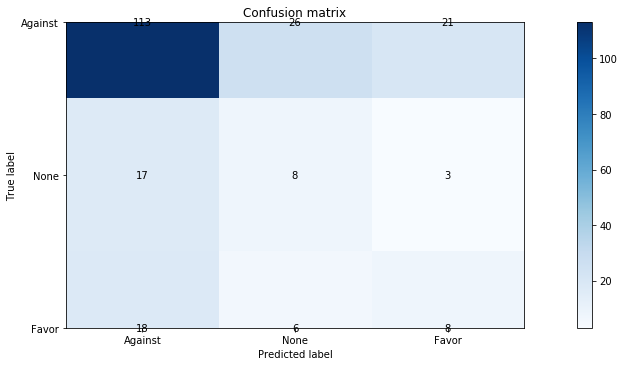

In [25]:
#show metrics
metrics(true_labels, test_probs)

In [26]:
#Hillary Clinton

#obtain subset data
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(['Hillary Clinton'], 'lstm_outputs1')
weights = {0: train_labels[:,0].sum(), 1:train_labels[:,1].sum(), 2:train_labels[:,2].sum()}


#train model
ff_mod.fit(
        train_data,
        train_labels,
        epochs=100,
        batch_size = 100,
        verbose=2,
        validation_split = 0.2,
        shuffle = True,
        class_weight = weights)

#make predictions
test_probs = ff_mod.predict(test_data)

Train on 551 samples, validate on 138 samples
Epoch 1/100
551/551 - 0s - loss: 253.5666 - categorical_accuracy: 0.6697 - val_loss: 171.0996 - val_categorical_accuracy: 0.8116
Epoch 2/100
551/551 - 0s - loss: 199.8391 - categorical_accuracy: 0.6951 - val_loss: 143.9854 - val_categorical_accuracy: 0.8261
Epoch 3/100
551/551 - 0s - loss: 194.7564 - categorical_accuracy: 0.7024 - val_loss: 137.7271 - val_categorical_accuracy: 0.8406
Epoch 4/100
551/551 - 0s - loss: 176.8738 - categorical_accuracy: 0.7169 - val_loss: 150.2069 - val_categorical_accuracy: 0.8261
Epoch 5/100
551/551 - 0s - loss: 165.4193 - categorical_accuracy: 0.7260 - val_loss: 134.8323 - val_categorical_accuracy: 0.8478
Epoch 6/100
551/551 - 0s - loss: 149.0935 - categorical_accuracy: 0.7477 - val_loss: 127.3217 - val_categorical_accuracy: 0.8406
Epoch 7/100
551/551 - 0s - loss: 149.1870 - categorical_accuracy: 0.7623 - val_loss: 127.0939 - val_categorical_accuracy: 0.8406
Epoch 8/100
551/551 - 0s - loss: 147.0215 - categor

551/551 - 0s - loss: 56.1088 - categorical_accuracy: 0.9093 - val_loss: 119.9522 - val_categorical_accuracy: 0.8696
Epoch 65/100
551/551 - 0s - loss: 49.3082 - categorical_accuracy: 0.9292 - val_loss: 121.0231 - val_categorical_accuracy: 0.8696
Epoch 66/100
551/551 - 0s - loss: 53.4488 - categorical_accuracy: 0.9165 - val_loss: 114.1011 - val_categorical_accuracy: 0.8623
Epoch 67/100
551/551 - 0s - loss: 47.0476 - categorical_accuracy: 0.9256 - val_loss: 121.6795 - val_categorical_accuracy: 0.8696
Epoch 68/100
551/551 - 0s - loss: 46.8055 - categorical_accuracy: 0.9310 - val_loss: 133.3059 - val_categorical_accuracy: 0.8696
Epoch 69/100
551/551 - 0s - loss: 49.5695 - categorical_accuracy: 0.9238 - val_loss: 138.0002 - val_categorical_accuracy: 0.8696
Epoch 70/100
551/551 - 0s - loss: 55.9238 - categorical_accuracy: 0.9093 - val_loss: 128.9244 - val_categorical_accuracy: 0.8696
Epoch 71/100
551/551 - 0s - loss: 49.4629 - categorical_accuracy: 0.9111 - val_loss: 124.4136 - val_categorica

F1 macro score: 0.4201904761904762
              precision    recall  f1-score   support

     Against       0.65      0.76      0.70       172
        None       0.48      0.38      0.43        78
       Favor       0.17      0.11      0.13        45

   micro avg       0.56      0.56      0.56       295
   macro avg       0.43      0.42      0.42       295
weighted avg       0.53      0.56      0.54       295



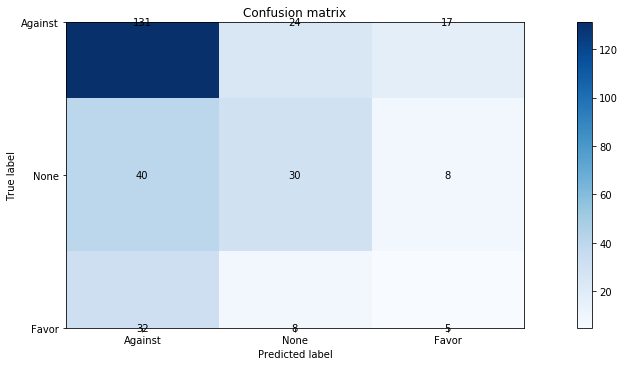

In [27]:
#show metrics
metrics(true_labels, test_probs)

In [28]:
#Abortion

#obtain subset data
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(['Legalization of Abortion'], 'lstm_outputs1')
weights = {0: train_labels[:,0].sum(), 1:train_labels[:,1].sum(), 2:train_labels[:,2].sum()}


#train model
ff_mod.fit(
        train_data,
        train_labels,
        epochs=100,
        batch_size = 100,
        verbose=2,
        validation_split = 0.2,
        shuffle = True,
        class_weight = weights)

#make predictions
test_probs = ff_mod.predict(test_data)

Train on 522 samples, validate on 131 samples
Epoch 1/100
522/522 - 0s - loss: 543.6515 - categorical_accuracy: 0.4732 - val_loss: 365.3191 - val_categorical_accuracy: 0.6489
Epoch 2/100
522/522 - 0s - loss: 466.8400 - categorical_accuracy: 0.5153 - val_loss: 306.6980 - val_categorical_accuracy: 0.6947
Epoch 3/100
522/522 - 0s - loss: 410.4810 - categorical_accuracy: 0.5326 - val_loss: 302.0811 - val_categorical_accuracy: 0.6565
Epoch 4/100
522/522 - 0s - loss: 341.6175 - categorical_accuracy: 0.5307 - val_loss: 344.9546 - val_categorical_accuracy: 0.6107
Epoch 5/100
522/522 - 0s - loss: 292.4246 - categorical_accuracy: 0.5881 - val_loss: 318.4474 - val_categorical_accuracy: 0.6336
Epoch 6/100
522/522 - 0s - loss: 254.2256 - categorical_accuracy: 0.5996 - val_loss: 277.1863 - val_categorical_accuracy: 0.6641
Epoch 7/100
522/522 - 0s - loss: 230.5368 - categorical_accuracy: 0.6264 - val_loss: 255.9678 - val_categorical_accuracy: 0.6794
Epoch 8/100
522/522 - 0s - loss: 219.8718 - categor

Epoch 64/100
522/522 - 0s - loss: 69.9472 - categorical_accuracy: 0.8812 - val_loss: 312.8012 - val_categorical_accuracy: 0.6565
Epoch 65/100
522/522 - 0s - loss: 67.1351 - categorical_accuracy: 0.8736 - val_loss: 290.1613 - val_categorical_accuracy: 0.6565
Epoch 66/100
522/522 - 0s - loss: 74.3141 - categorical_accuracy: 0.8716 - val_loss: 302.3580 - val_categorical_accuracy: 0.6565
Epoch 67/100
522/522 - 0s - loss: 69.8724 - categorical_accuracy: 0.8812 - val_loss: 318.2417 - val_categorical_accuracy: 0.6565
Epoch 68/100
522/522 - 0s - loss: 66.1005 - categorical_accuracy: 0.8870 - val_loss: 332.0824 - val_categorical_accuracy: 0.6260
Epoch 69/100
522/522 - 0s - loss: 67.0666 - categorical_accuracy: 0.8870 - val_loss: 324.3058 - val_categorical_accuracy: 0.6336
Epoch 70/100
522/522 - 0s - loss: 62.2764 - categorical_accuracy: 0.9080 - val_loss: 306.9440 - val_categorical_accuracy: 0.6412
Epoch 71/100
522/522 - 0s - loss: 57.4097 - categorical_accuracy: 0.9023 - val_loss: 305.5323 - v

F1 macro score: 0.49881357680800575
              precision    recall  f1-score   support

     Against       0.76      0.68      0.72       189
        None       0.36      0.58      0.44        45
       Favor       0.37      0.30      0.33        46

   micro avg       0.60      0.60      0.60       280
   macro avg       0.50      0.52      0.50       280
weighted avg       0.63      0.60      0.61       280



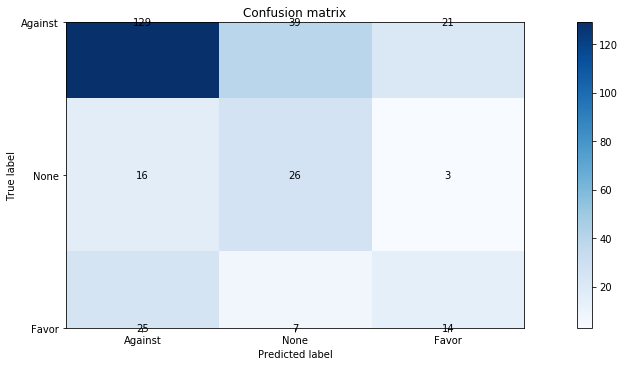

In [29]:
#show metrics
metrics(true_labels, test_probs)

In [30]:
#Climate

#obtain subset data
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(['Climate Change is a Real Concern'], 'lstm_outputs1')
weights = {0: train_labels[:,0].sum(), 1:train_labels[:,1].sum(), 2:train_labels[:,2].sum()}


#train model
ff_mod.fit(
        train_data,
        train_labels,
        epochs=100,
        batch_size = 100,
        verbose=2,
        validation_split = 0.2,
        shuffle = True,
        class_weight = weights)

#make predictions
test_probs = ff_mod.predict(test_data)

Train on 316 samples, validate on 79 samples
Epoch 1/100
316/316 - 0s - loss: 429.4705 - categorical_accuracy: 0.4905 - val_loss: 271.5032 - val_categorical_accuracy: 0.6076
Epoch 2/100
316/316 - 0s - loss: 234.2780 - categorical_accuracy: 0.6392 - val_loss: 174.8622 - val_categorical_accuracy: 0.6203
Epoch 3/100
316/316 - 0s - loss: 169.4078 - categorical_accuracy: 0.6804 - val_loss: 186.7228 - val_categorical_accuracy: 0.5949
Epoch 4/100
316/316 - 0s - loss: 160.1803 - categorical_accuracy: 0.6867 - val_loss: 150.5075 - val_categorical_accuracy: 0.6582
Epoch 5/100
316/316 - 0s - loss: 136.8807 - categorical_accuracy: 0.7215 - val_loss: 133.5459 - val_categorical_accuracy: 0.6962
Epoch 6/100
316/316 - 0s - loss: 103.3880 - categorical_accuracy: 0.7627 - val_loss: 128.9802 - val_categorical_accuracy: 0.6962
Epoch 7/100
316/316 - 0s - loss: 105.4155 - categorical_accuracy: 0.7722 - val_loss: 129.8894 - val_categorical_accuracy: 0.7215
Epoch 8/100
316/316 - 0s - loss: 97.0603 - categoric

Epoch 65/100
316/316 - 0s - loss: 35.2265 - categorical_accuracy: 0.9304 - val_loss: 147.4547 - val_categorical_accuracy: 0.7722
Epoch 66/100
316/316 - 0s - loss: 33.0168 - categorical_accuracy: 0.9462 - val_loss: 148.5845 - val_categorical_accuracy: 0.7595
Epoch 67/100
316/316 - 0s - loss: 32.3132 - categorical_accuracy: 0.9399 - val_loss: 152.4722 - val_categorical_accuracy: 0.7468
Epoch 68/100
316/316 - 0s - loss: 28.3197 - categorical_accuracy: 0.9525 - val_loss: 153.5356 - val_categorical_accuracy: 0.7342
Epoch 69/100
316/316 - 0s - loss: 34.4246 - categorical_accuracy: 0.9272 - val_loss: 151.8873 - val_categorical_accuracy: 0.7595
Epoch 70/100
316/316 - 0s - loss: 30.9520 - categorical_accuracy: 0.9525 - val_loss: 151.1595 - val_categorical_accuracy: 0.7722
Epoch 71/100
316/316 - 0s - loss: 34.7842 - categorical_accuracy: 0.9272 - val_loss: 150.8002 - val_categorical_accuracy: 0.7595
Epoch 72/100
316/316 - 0s - loss: 33.1345 - categorical_accuracy: 0.9367 - val_loss: 150.6724 - v

F1 macro score: 0.4723809523809524
              precision    recall  f1-score   support

     Against       0.00      0.00      0.00        11
        None       0.53      0.60      0.56        35
       Favor       0.84      0.88      0.86       123

   micro avg       0.76      0.76      0.76       169
   macro avg       0.45      0.49      0.47       169
weighted avg       0.72      0.76      0.74       169



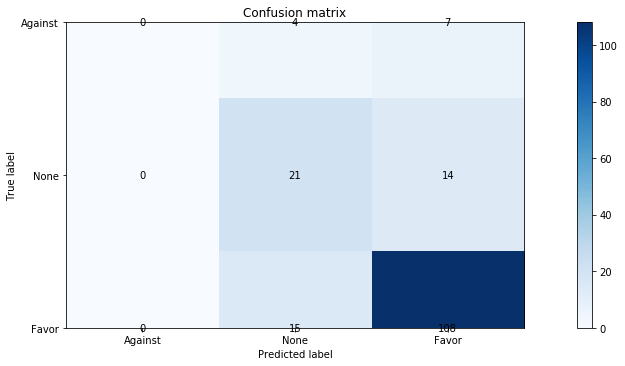

In [31]:
#show metrics
metrics(true_labels, test_probs)

In [32]:
#Feminism

#obtain subset data
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(['Feminist Movement'], 'lstm_outputs1')
weights = {0: train_labels[:,0].sum(), 1:train_labels[:,1].sum(), 2:train_labels[:,2].sum()}


#train model
ff_mod.fit(
        train_data,
        train_labels,
        epochs=100,
        batch_size = 100,
        verbose=2,
        validation_split = 0.2,
        shuffle = True,
        class_weight = weights)

#make predictions
test_probs = ff_mod.predict(test_data)

Train on 531 samples, validate on 133 samples
Epoch 1/100
531/531 - 0s - loss: 723.2529 - categorical_accuracy: 0.4689 - val_loss: 424.1792 - val_categorical_accuracy: 0.5414
Epoch 2/100
531/531 - 0s - loss: 277.0751 - categorical_accuracy: 0.5650 - val_loss: 155.7251 - val_categorical_accuracy: 0.8271
Epoch 3/100
531/531 - 0s - loss: 296.4969 - categorical_accuracy: 0.5537 - val_loss: 207.8160 - val_categorical_accuracy: 0.7293
Epoch 4/100
531/531 - 0s - loss: 217.1034 - categorical_accuracy: 0.6234 - val_loss: 256.0624 - val_categorical_accuracy: 0.6541
Epoch 5/100
531/531 - 0s - loss: 217.8205 - categorical_accuracy: 0.6384 - val_loss: 206.1238 - val_categorical_accuracy: 0.7068
Epoch 6/100
531/531 - 0s - loss: 200.6316 - categorical_accuracy: 0.6723 - val_loss: 178.6073 - val_categorical_accuracy: 0.7293
Epoch 7/100
531/531 - 0s - loss: 172.4763 - categorical_accuracy: 0.7043 - val_loss: 242.4178 - val_categorical_accuracy: 0.6842
Epoch 8/100
531/531 - 0s - loss: 185.1080 - categor

531/531 - 0s - loss: 48.2356 - categorical_accuracy: 0.9284 - val_loss: 338.7850 - val_categorical_accuracy: 0.7218
Epoch 65/100
531/531 - 0s - loss: 43.8925 - categorical_accuracy: 0.9510 - val_loss: 316.7437 - val_categorical_accuracy: 0.7293
Epoch 66/100
531/531 - 0s - loss: 52.2482 - categorical_accuracy: 0.9209 - val_loss: 294.4085 - val_categorical_accuracy: 0.7293
Epoch 67/100
531/531 - 0s - loss: 45.2862 - categorical_accuracy: 0.9435 - val_loss: 331.4428 - val_categorical_accuracy: 0.7143
Epoch 68/100
531/531 - 0s - loss: 41.8067 - categorical_accuracy: 0.9435 - val_loss: 347.0270 - val_categorical_accuracy: 0.7218
Epoch 69/100
531/531 - 0s - loss: 47.8193 - categorical_accuracy: 0.9379 - val_loss: 355.5525 - val_categorical_accuracy: 0.7143
Epoch 70/100
531/531 - 0s - loss: 47.3126 - categorical_accuracy: 0.9322 - val_loss: 366.4393 - val_categorical_accuracy: 0.7068
Epoch 71/100
531/531 - 0s - loss: 44.5656 - categorical_accuracy: 0.9492 - val_loss: 360.3323 - val_categorica

F1 macro score: 0.4715967905592646
              precision    recall  f1-score   support

     Against       0.72      0.51      0.60       183
        None       0.46      0.48      0.47        44
       Favor       0.27      0.50      0.35        58

   micro avg       0.51      0.51      0.51       285
   macro avg       0.48      0.50      0.47       285
weighted avg       0.59      0.51      0.53       285



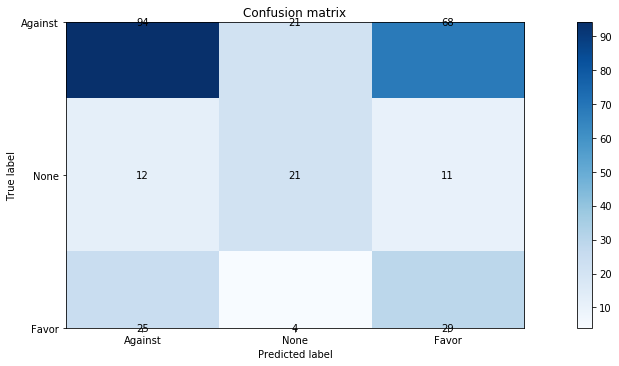

In [33]:
#show metrics
metrics(true_labels, test_probs)

In [34]:
#All

#obtain subset data
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(['Hillary Clinton', 
                                                                              'Legalization of Abortion', 
                                                                              'Climate Change is a Real Concern',
                                                                              'Feminist Movement', 
                                                                              'Atheism'], 'lstm_outputs1')
weights = {0: train_labels[:,0].sum(), 1:train_labels[:,1].sum(), 2:train_labels[:,2].sum()}


#train model
ff_mod.fit(
        train_data,
        train_labels,
        epochs=100,
        batch_size = 100,
        verbose=2,
        validation_split = 0.2,
        shuffle = True,
        class_weight = weights)

#make predictions
test_probs = ff_mod.predict(test_data)

Train on 2331 samples, validate on 583 samples
Epoch 1/100
2331/2331 - 1s - loss: 808.7135 - categorical_accuracy: 0.7181 - val_loss: 908.4848 - val_categorical_accuracy: 0.6878
Epoch 2/100
2331/2331 - 1s - loss: 585.1120 - categorical_accuracy: 0.7533 - val_loss: 940.6571 - val_categorical_accuracy: 0.6552
Epoch 3/100
2331/2331 - 1s - loss: 505.9278 - categorical_accuracy: 0.7786 - val_loss: 1075.2875 - val_categorical_accuracy: 0.6415
Epoch 4/100
2331/2331 - 1s - loss: 452.2822 - categorical_accuracy: 0.7958 - val_loss: 1117.9377 - val_categorical_accuracy: 0.6295
Epoch 5/100
2331/2331 - 1s - loss: 439.3386 - categorical_accuracy: 0.8160 - val_loss: 1084.3223 - val_categorical_accuracy: 0.6312
Epoch 6/100
2331/2331 - 1s - loss: 406.9364 - categorical_accuracy: 0.8258 - val_loss: 1338.8438 - val_categorical_accuracy: 0.5901
Epoch 7/100
2331/2331 - 1s - loss: 423.0721 - categorical_accuracy: 0.8151 - val_loss: 1223.5584 - val_categorical_accuracy: 0.6158
Epoch 8/100
2331/2331 - 1s - lo

Epoch 63/100
2331/2331 - 1s - loss: 200.2724 - categorical_accuracy: 0.9258 - val_loss: 2356.7865 - val_categorical_accuracy: 0.5643
Epoch 64/100
2331/2331 - 1s - loss: 186.7707 - categorical_accuracy: 0.9254 - val_loss: 2514.1483 - val_categorical_accuracy: 0.5352
Epoch 65/100
2331/2331 - 1s - loss: 211.8410 - categorical_accuracy: 0.9189 - val_loss: 2477.1999 - val_categorical_accuracy: 0.5489
Epoch 66/100
2331/2331 - 2s - loss: 182.0170 - categorical_accuracy: 0.9279 - val_loss: 2448.8153 - val_categorical_accuracy: 0.5420
Epoch 67/100
2331/2331 - 2s - loss: 187.8851 - categorical_accuracy: 0.9279 - val_loss: 2366.8085 - val_categorical_accuracy: 0.5437
Epoch 68/100
2331/2331 - 2s - loss: 185.7085 - categorical_accuracy: 0.9326 - val_loss: 2545.7449 - val_categorical_accuracy: 0.5437
Epoch 69/100
2331/2331 - 1s - loss: 193.5047 - categorical_accuracy: 0.9206 - val_loss: 2375.7139 - val_categorical_accuracy: 0.5557
Epoch 70/100
2331/2331 - 1s - loss: 192.7660 - categorical_accuracy: 

F1 macro score: 0.45759950614658224
              precision    recall  f1-score   support

     Against       0.65      0.60      0.63       715
        None       0.34      0.42      0.37       230
       Favor       0.37      0.38      0.37       304

   micro avg       0.51      0.51      0.51      1249
   macro avg       0.45      0.46      0.46      1249
weighted avg       0.53      0.51      0.52      1249



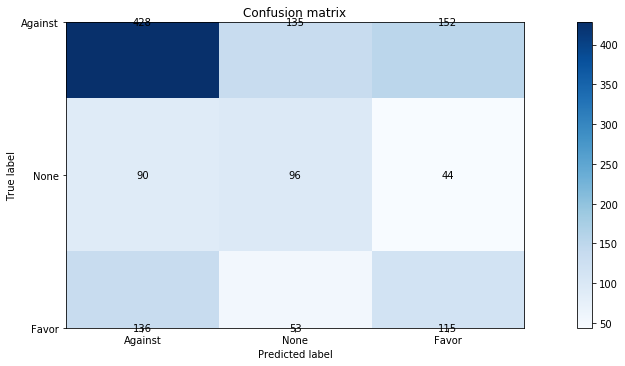

In [35]:
#show metrics
metrics(true_labels, test_probs)

# Run LSTM on 'LSTM2' outputs

In [36]:
#Atheism

#obtain subset data
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(['Atheism'], 'lstm_outputs2')
weights = {0: train_labels[:,0].sum(), 1:train_labels[:,1].sum(), 2:train_labels[:,2].sum()}


#train model
ff_mod.fit(
        train_data,
        train_labels,
        epochs=100,
        batch_size = 100,
        verbose=2,
        validation_split = 0.2,
        shuffle = True,
        class_weight = weights)

#make predictions
test_probs = ff_mod.predict(test_data)

Train on 410 samples, validate on 103 samples
Epoch 1/100
410/410 - 0s - loss: 291.8009 - categorical_accuracy: 0.6561 - val_loss: 201.2447 - val_categorical_accuracy: 0.8058
Epoch 2/100
410/410 - 0s - loss: 245.9020 - categorical_accuracy: 0.6927 - val_loss: 184.5669 - val_categorical_accuracy: 0.8447
Epoch 3/100
410/410 - 0s - loss: 212.1591 - categorical_accuracy: 0.7146 - val_loss: 175.0254 - val_categorical_accuracy: 0.8544
Epoch 4/100
410/410 - 0s - loss: 205.5466 - categorical_accuracy: 0.6854 - val_loss: 160.7173 - val_categorical_accuracy: 0.8835
Epoch 5/100
410/410 - 0s - loss: 198.9239 - categorical_accuracy: 0.7146 - val_loss: 163.1186 - val_categorical_accuracy: 0.8641
Epoch 6/100
410/410 - 0s - loss: 158.5828 - categorical_accuracy: 0.7537 - val_loss: 192.0957 - val_categorical_accuracy: 0.8641
Epoch 7/100
410/410 - 0s - loss: 131.0845 - categorical_accuracy: 0.7707 - val_loss: 192.2534 - val_categorical_accuracy: 0.8544
Epoch 8/100
410/410 - 0s - loss: 137.6889 - categor

Epoch 65/100
410/410 - 0s - loss: 37.9427 - categorical_accuracy: 0.9366 - val_loss: 216.2202 - val_categorical_accuracy: 0.8155
Epoch 66/100
410/410 - 0s - loss: 41.4183 - categorical_accuracy: 0.9439 - val_loss: 200.6345 - val_categorical_accuracy: 0.8350
Epoch 67/100
410/410 - 0s - loss: 39.2887 - categorical_accuracy: 0.9439 - val_loss: 181.7205 - val_categorical_accuracy: 0.8544
Epoch 68/100
410/410 - 0s - loss: 39.7092 - categorical_accuracy: 0.9317 - val_loss: 164.2735 - val_categorical_accuracy: 0.8835
Epoch 69/100
410/410 - 0s - loss: 35.8817 - categorical_accuracy: 0.9415 - val_loss: 176.3773 - val_categorical_accuracy: 0.8738
Epoch 70/100
410/410 - 0s - loss: 38.4624 - categorical_accuracy: 0.9268 - val_loss: 205.0636 - val_categorical_accuracy: 0.8350
Epoch 71/100
410/410 - 0s - loss: 38.4805 - categorical_accuracy: 0.9366 - val_loss: 215.4389 - val_categorical_accuracy: 0.8350
Epoch 72/100
410/410 - 0s - loss: 36.7255 - categorical_accuracy: 0.9366 - val_loss: 215.9822 - v

F1 macro score: 0.4707075624797144
              precision    recall  f1-score   support

     Against       0.82      0.69      0.75       160
        None       0.27      0.50      0.35        28
       Favor       0.30      0.31      0.31        32

   micro avg       0.61      0.61      0.61       220
   macro avg       0.46      0.50      0.47       220
weighted avg       0.67      0.61      0.64       220



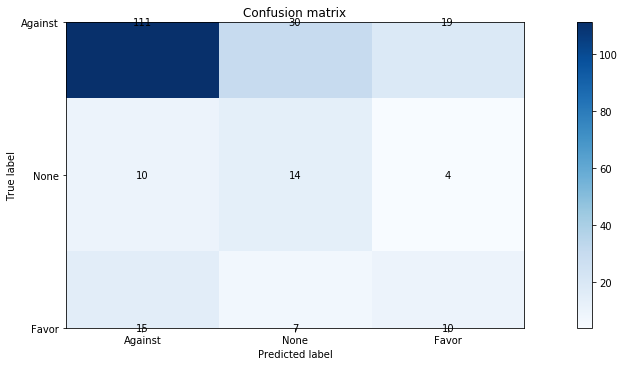

In [37]:
#show metrics
metrics(true_labels, test_probs)

In [38]:
#Hillary Clinton

#obtain subset data
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(['Hillary Clinton'], 'lstm_outputs2')
weights = {0: train_labels[:,0].sum(), 1:train_labels[:,1].sum(), 2:train_labels[:,2].sum()}


#train model
ff_mod.fit(
        train_data,
        train_labels,
        epochs=100,
        batch_size = 100,
        verbose=2,
        validation_split = 0.2,
        shuffle = True,
        class_weight = weights)

#make predictions
test_probs = ff_mod.predict(test_data)

Train on 551 samples, validate on 138 samples
Epoch 1/100
551/551 - 0s - loss: 411.7096 - categorical_accuracy: 0.6715 - val_loss: 197.5550 - val_categorical_accuracy: 0.8333
Epoch 2/100
551/551 - 0s - loss: 299.4491 - categorical_accuracy: 0.6933 - val_loss: 172.6667 - val_categorical_accuracy: 0.8696
Epoch 3/100
551/551 - 0s - loss: 239.8600 - categorical_accuracy: 0.7241 - val_loss: 175.4117 - val_categorical_accuracy: 0.8116
Epoch 4/100
551/551 - 0s - loss: 237.5018 - categorical_accuracy: 0.7078 - val_loss: 154.9012 - val_categorical_accuracy: 0.8478
Epoch 5/100
551/551 - 0s - loss: 176.7870 - categorical_accuracy: 0.7477 - val_loss: 157.3613 - val_categorical_accuracy: 0.8261
Epoch 6/100
551/551 - 0s - loss: 167.8382 - categorical_accuracy: 0.7750 - val_loss: 153.8580 - val_categorical_accuracy: 0.8551
Epoch 7/100
551/551 - 0s - loss: 156.6826 - categorical_accuracy: 0.7895 - val_loss: 155.8632 - val_categorical_accuracy: 0.8261
Epoch 8/100
551/551 - 0s - loss: 148.8810 - categor

551/551 - 0s - loss: 46.7320 - categorical_accuracy: 0.9274 - val_loss: 198.0800 - val_categorical_accuracy: 0.7826
Epoch 65/100
551/551 - 0s - loss: 38.6466 - categorical_accuracy: 0.9419 - val_loss: 212.5438 - val_categorical_accuracy: 0.7754
Epoch 66/100
551/551 - 0s - loss: 50.6150 - categorical_accuracy: 0.9292 - val_loss: 208.4361 - val_categorical_accuracy: 0.7754
Epoch 67/100
551/551 - 0s - loss: 52.2616 - categorical_accuracy: 0.9310 - val_loss: 186.4710 - val_categorical_accuracy: 0.7899
Epoch 68/100
551/551 - 0s - loss: 42.2262 - categorical_accuracy: 0.9492 - val_loss: 185.9759 - val_categorical_accuracy: 0.7971
Epoch 69/100
551/551 - 0s - loss: 41.5124 - categorical_accuracy: 0.9328 - val_loss: 193.1170 - val_categorical_accuracy: 0.7971
Epoch 70/100
551/551 - 0s - loss: 40.4147 - categorical_accuracy: 0.9456 - val_loss: 195.1782 - val_categorical_accuracy: 0.7899
Epoch 71/100
551/551 - 0s - loss: 47.0290 - categorical_accuracy: 0.9220 - val_loss: 198.4516 - val_categorica

F1 macro score: 0.48960449064205025
              precision    recall  f1-score   support

     Against       0.70      0.78      0.74       172
        None       0.51      0.53      0.52        78
       Favor       0.33      0.16      0.21        45

   micro avg       0.62      0.62      0.62       295
   macro avg       0.51      0.49      0.49       295
weighted avg       0.59      0.62      0.60       295



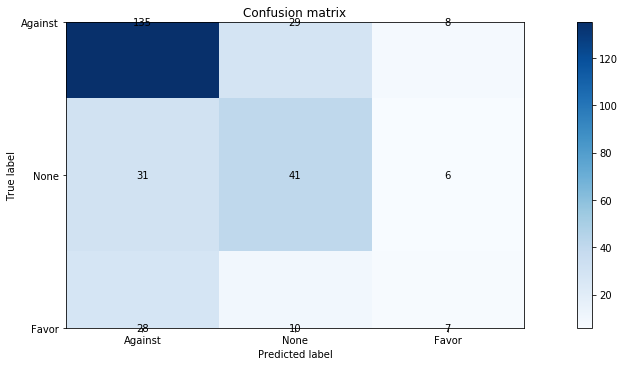

In [39]:
#show metrics
metrics(true_labels, test_probs)

In [40]:
#Abortion

#obtain subset data
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(['Legalization of Abortion'], 'lstm_outputs2')
weights = {0: train_labels[:,0].sum(), 1:train_labels[:,1].sum(), 2:train_labels[:,2].sum()}


#train model
ff_mod.fit(
        train_data,
        train_labels,
        epochs=100,
        batch_size = 100,
        verbose=2,
        validation_split = 0.2,
        shuffle = True,
        class_weight = weights)

#make predictions
test_probs = ff_mod.predict(test_data)

Train on 522 samples, validate on 131 samples
Epoch 1/100
522/522 - 0s - loss: 502.7618 - categorical_accuracy: 0.5594 - val_loss: 615.8884 - val_categorical_accuracy: 0.5496
Epoch 2/100
522/522 - 0s - loss: 451.7811 - categorical_accuracy: 0.5402 - val_loss: 522.1854 - val_categorical_accuracy: 0.5802
Epoch 3/100
522/522 - 0s - loss: 378.9191 - categorical_accuracy: 0.5709 - val_loss: 479.1735 - val_categorical_accuracy: 0.5649
Epoch 4/100
522/522 - 0s - loss: 326.1731 - categorical_accuracy: 0.5939 - val_loss: 505.3444 - val_categorical_accuracy: 0.5115
Epoch 5/100
522/522 - 0s - loss: 283.9753 - categorical_accuracy: 0.6149 - val_loss: 456.6621 - val_categorical_accuracy: 0.5038
Epoch 6/100
522/522 - 0s - loss: 256.5131 - categorical_accuracy: 0.6130 - val_loss: 421.2322 - val_categorical_accuracy: 0.5191
Epoch 7/100
522/522 - 0s - loss: 225.0190 - categorical_accuracy: 0.6341 - val_loss: 391.9824 - val_categorical_accuracy: 0.5191
Epoch 8/100
522/522 - 0s - loss: 196.8583 - categor

Epoch 64/100
522/522 - 0s - loss: 76.2501 - categorical_accuracy: 0.8697 - val_loss: 432.4018 - val_categorical_accuracy: 0.5267
Epoch 65/100
522/522 - 0s - loss: 69.9276 - categorical_accuracy: 0.8736 - val_loss: 435.8259 - val_categorical_accuracy: 0.5267
Epoch 66/100
522/522 - 0s - loss: 76.4775 - categorical_accuracy: 0.8467 - val_loss: 431.0604 - val_categorical_accuracy: 0.5344
Epoch 67/100
522/522 - 0s - loss: 65.8934 - categorical_accuracy: 0.8927 - val_loss: 417.2992 - val_categorical_accuracy: 0.5573
Epoch 68/100
522/522 - 0s - loss: 69.9326 - categorical_accuracy: 0.8812 - val_loss: 422.7561 - val_categorical_accuracy: 0.5573
Epoch 69/100
522/522 - 0s - loss: 68.3826 - categorical_accuracy: 0.8755 - val_loss: 444.0537 - val_categorical_accuracy: 0.5420
Epoch 70/100
522/522 - 0s - loss: 65.5237 - categorical_accuracy: 0.8946 - val_loss: 451.6664 - val_categorical_accuracy: 0.5267
Epoch 71/100
522/522 - 0s - loss: 77.9836 - categorical_accuracy: 0.8544 - val_loss: 451.2796 - v

F1 macro score: 0.49512644046094745
              precision    recall  f1-score   support

     Against       0.77      0.67      0.72       189
        None       0.31      0.58      0.41        45
       Favor       0.45      0.30      0.36        46

   micro avg       0.60      0.60      0.60       280
   macro avg       0.51      0.52      0.50       280
weighted avg       0.64      0.60      0.61       280



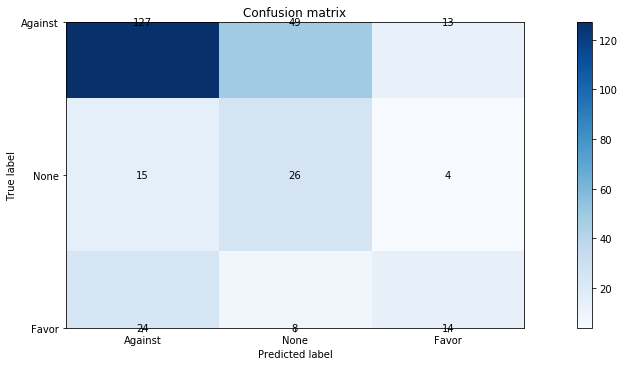

In [41]:
#show metrics
metrics(true_labels, test_probs)

In [42]:
#Climate

#obtain subset data
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(['Climate Change is a Real Concern'], 'lstm_outputs2')
weights = {0: train_labels[:,0].sum(), 1:train_labels[:,1].sum(), 2:train_labels[:,2].sum()}


#train model
ff_mod.fit(
        train_data,
        train_labels,
        epochs=100,
        batch_size = 100,
        verbose=2,
        validation_split = 0.2,
        shuffle = True,
        class_weight = weights)

#make predictions
test_probs = ff_mod.predict(test_data)

Train on 316 samples, validate on 79 samples
Epoch 1/100
316/316 - 0s - loss: 378.9250 - categorical_accuracy: 0.5095 - val_loss: 259.0669 - val_categorical_accuracy: 0.6329
Epoch 2/100
316/316 - 0s - loss: 199.8915 - categorical_accuracy: 0.6582 - val_loss: 180.8624 - val_categorical_accuracy: 0.6329
Epoch 3/100
316/316 - 0s - loss: 180.2387 - categorical_accuracy: 0.6772 - val_loss: 154.6998 - val_categorical_accuracy: 0.6203
Epoch 4/100
316/316 - 0s - loss: 143.2197 - categorical_accuracy: 0.6994 - val_loss: 108.9173 - val_categorical_accuracy: 0.7089
Epoch 5/100
316/316 - 0s - loss: 107.0384 - categorical_accuracy: 0.8038 - val_loss: 138.7032 - val_categorical_accuracy: 0.6962
Epoch 6/100
316/316 - 0s - loss: 110.8858 - categorical_accuracy: 0.7943 - val_loss: 132.2723 - val_categorical_accuracy: 0.7089
Epoch 7/100
316/316 - 0s - loss: 104.8796 - categorical_accuracy: 0.7816 - val_loss: 98.0984 - val_categorical_accuracy: 0.7848
Epoch 8/100
316/316 - 0s - loss: 103.9395 - categoric

Epoch 65/100
316/316 - 0s - loss: 28.1031 - categorical_accuracy: 0.9557 - val_loss: 135.4898 - val_categorical_accuracy: 0.7468
Epoch 66/100
316/316 - 0s - loss: 29.8856 - categorical_accuracy: 0.9462 - val_loss: 135.9559 - val_categorical_accuracy: 0.7722
Epoch 67/100
316/316 - 0s - loss: 28.1520 - categorical_accuracy: 0.9430 - val_loss: 136.1179 - val_categorical_accuracy: 0.7595
Epoch 68/100
316/316 - 0s - loss: 28.4959 - categorical_accuracy: 0.9525 - val_loss: 140.2583 - val_categorical_accuracy: 0.7468
Epoch 69/100
316/316 - 0s - loss: 23.4187 - categorical_accuracy: 0.9652 - val_loss: 147.1574 - val_categorical_accuracy: 0.7595
Epoch 70/100
316/316 - 0s - loss: 26.4658 - categorical_accuracy: 0.9525 - val_loss: 150.7390 - val_categorical_accuracy: 0.7468
Epoch 71/100
316/316 - 0s - loss: 29.3766 - categorical_accuracy: 0.9525 - val_loss: 147.5605 - val_categorical_accuracy: 0.7468
Epoch 72/100
316/316 - 0s - loss: 29.5416 - categorical_accuracy: 0.9494 - val_loss: 141.4319 - v

F1 macro score: 0.46961246961246966
              precision    recall  f1-score   support

     Against       0.00      0.00      0.00        11
        None       0.54      0.60      0.57        35
       Favor       0.82      0.86      0.84       123

   micro avg       0.75      0.75      0.75       169
   macro avg       0.45      0.49      0.47       169
weighted avg       0.71      0.75      0.73       169



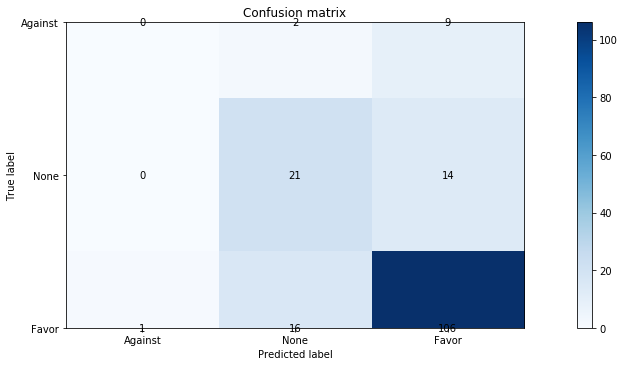

In [43]:
#show metrics
metrics(true_labels, test_probs)

In [44]:
#Feminism

#obtain subset data
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(['Feminist Movement'], 'lstm_outputs2')
weights = {0: train_labels[:,0].sum(), 1:train_labels[:,1].sum(), 2:train_labels[:,2].sum()}


#train model
ff_mod.fit(
        train_data,
        train_labels,
        epochs=100,
        batch_size = 100,
        verbose=2,
        validation_split = 0.2,
        shuffle = True,
        class_weight = weights)

#make predictions
test_probs = ff_mod.predict(test_data)

Train on 531 samples, validate on 133 samples
Epoch 1/100
531/531 - 0s - loss: 612.4674 - categorical_accuracy: 0.4991 - val_loss: 333.3610 - val_categorical_accuracy: 0.6090
Epoch 2/100
531/531 - 0s - loss: 320.9660 - categorical_accuracy: 0.5179 - val_loss: 159.3255 - val_categorical_accuracy: 0.8346
Epoch 3/100
531/531 - 0s - loss: 291.1795 - categorical_accuracy: 0.5348 - val_loss: 282.5032 - val_categorical_accuracy: 0.6617
Epoch 4/100
531/531 - 0s - loss: 247.8384 - categorical_accuracy: 0.6252 - val_loss: 226.6172 - val_categorical_accuracy: 0.6767
Epoch 5/100
531/531 - 0s - loss: 257.2381 - categorical_accuracy: 0.6045 - val_loss: 158.4696 - val_categorical_accuracy: 0.7594
Epoch 6/100
531/531 - 0s - loss: 204.5151 - categorical_accuracy: 0.6365 - val_loss: 187.5082 - val_categorical_accuracy: 0.7444
Epoch 7/100
531/531 - 0s - loss: 182.4499 - categorical_accuracy: 0.6648 - val_loss: 158.1793 - val_categorical_accuracy: 0.8045
Epoch 8/100
531/531 - 0s - loss: 159.6861 - categor

531/531 - 0s - loss: 45.3696 - categorical_accuracy: 0.9454 - val_loss: 272.3580 - val_categorical_accuracy: 0.7293
Epoch 65/100
531/531 - 0s - loss: 49.3325 - categorical_accuracy: 0.9284 - val_loss: 312.5309 - val_categorical_accuracy: 0.7143
Epoch 66/100
531/531 - 0s - loss: 43.5601 - categorical_accuracy: 0.9454 - val_loss: 275.9884 - val_categorical_accuracy: 0.7293
Epoch 67/100
531/531 - 0s - loss: 43.2583 - categorical_accuracy: 0.9548 - val_loss: 257.9229 - val_categorical_accuracy: 0.7519
Epoch 68/100
531/531 - 0s - loss: 44.8588 - categorical_accuracy: 0.9341 - val_loss: 264.2907 - val_categorical_accuracy: 0.7444
Epoch 69/100
531/531 - 0s - loss: 45.0343 - categorical_accuracy: 0.9397 - val_loss: 310.1640 - val_categorical_accuracy: 0.7143
Epoch 70/100
531/531 - 0s - loss: 43.1141 - categorical_accuracy: 0.9454 - val_loss: 308.7853 - val_categorical_accuracy: 0.7143
Epoch 71/100
531/531 - 0s - loss: 39.6803 - categorical_accuracy: 0.9567 - val_loss: 302.0472 - val_categorica

F1 macro score: 0.4464579308541765
              precision    recall  f1-score   support

     Against       0.72      0.58      0.64       183
        None       0.38      0.36      0.37        44
       Favor       0.26      0.43      0.33        58

   micro avg       0.52      0.52      0.52       285
   macro avg       0.45      0.46      0.45       285
weighted avg       0.57      0.52      0.54       285



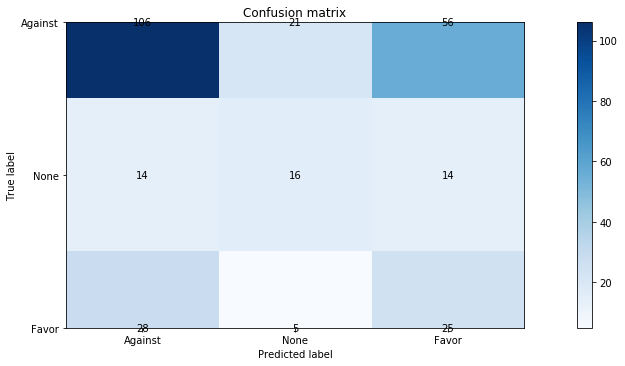

In [45]:
#show metrics
metrics(true_labels, test_probs)

In [46]:
#All

#obtain subset data
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(['Hillary Clinton', 
                                                                              'Legalization of Abortion', 
                                                                              'Climate Change is a Real Concern',
                                                                              'Feminist Movement', 
                                                                              'Atheism'], 'lstm_outputs2')
weights = {0: train_labels[:,0].sum(), 1:train_labels[:,1].sum(), 2:train_labels[:,2].sum()}


#train model
ff_mod.fit(
        train_data,
        train_labels,
        epochs=100,
        batch_size = 100,
        verbose=2,
        validation_split = 0.2,
        shuffle = True,
        class_weight = weights)

#make predictions
test_probs = ff_mod.predict(test_data)

Train on 2331 samples, validate on 583 samples
Epoch 1/100
2331/2331 - 2s - loss: 749.4584 - categorical_accuracy: 0.7503 - val_loss: 1294.0392 - val_categorical_accuracy: 0.6141
Epoch 2/100
2331/2331 - 1s - loss: 557.9274 - categorical_accuracy: 0.7808 - val_loss: 1207.7542 - val_categorical_accuracy: 0.6329
Epoch 3/100
2331/2331 - 1s - loss: 475.5231 - categorical_accuracy: 0.7911 - val_loss: 1174.2769 - val_categorical_accuracy: 0.6621
Epoch 4/100
2331/2331 - 1s - loss: 459.9640 - categorical_accuracy: 0.8031 - val_loss: 1294.9227 - val_categorical_accuracy: 0.6158
Epoch 5/100
2331/2331 - 1s - loss: 456.8995 - categorical_accuracy: 0.8125 - val_loss: 1208.0417 - val_categorical_accuracy: 0.6312
Epoch 6/100
2331/2331 - 1s - loss: 394.9894 - categorical_accuracy: 0.8271 - val_loss: 1304.9132 - val_categorical_accuracy: 0.6278
Epoch 7/100
2331/2331 - 1s - loss: 368.4159 - categorical_accuracy: 0.8430 - val_loss: 1295.2255 - val_categorical_accuracy: 0.6346
Epoch 8/100
2331/2331 - 1s - 

Epoch 63/100
2331/2331 - 1s - loss: 168.2611 - categorical_accuracy: 0.9374 - val_loss: 2473.1388 - val_categorical_accuracy: 0.5746
Epoch 64/100
2331/2331 - 1s - loss: 178.2123 - categorical_accuracy: 0.9292 - val_loss: 2445.5166 - val_categorical_accuracy: 0.5763
Epoch 65/100
2331/2331 - 2s - loss: 149.7582 - categorical_accuracy: 0.9412 - val_loss: 2453.6968 - val_categorical_accuracy: 0.5746
Epoch 66/100
2331/2331 - 1s - loss: 171.3990 - categorical_accuracy: 0.9305 - val_loss: 2483.6476 - val_categorical_accuracy: 0.5695
Epoch 67/100
2331/2331 - 1s - loss: 168.9128 - categorical_accuracy: 0.9387 - val_loss: 2492.1958 - val_categorical_accuracy: 0.5678
Epoch 68/100
2331/2331 - 2s - loss: 160.7704 - categorical_accuracy: 0.9425 - val_loss: 2528.8495 - val_categorical_accuracy: 0.5540
Epoch 69/100
2331/2331 - 1s - loss: 167.6999 - categorical_accuracy: 0.9387 - val_loss: 2533.5466 - val_categorical_accuracy: 0.5540
Epoch 70/100
2331/2331 - 2s - loss: 142.4669 - categorical_accuracy: 

F1 macro score: 0.5049145283561649
              precision    recall  f1-score   support

     Against       0.69      0.61      0.65       715
        None       0.35      0.49      0.41       230
       Favor       0.47      0.45      0.46       304

   micro avg       0.55      0.55      0.55      1249
   macro avg       0.50      0.52      0.50      1249
weighted avg       0.57      0.55      0.56      1249



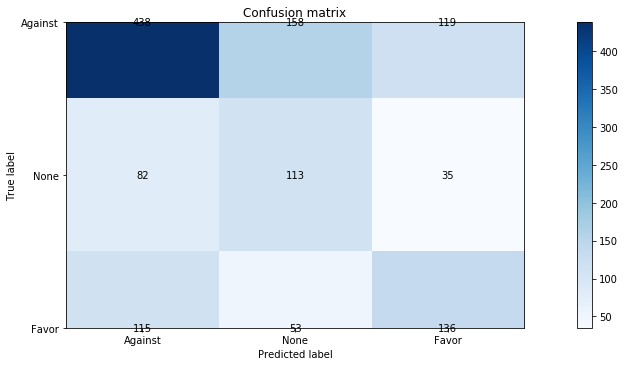

In [47]:
#show metrics
metrics(true_labels, test_probs)